In [20]:
#CAPSTONE PROJECT

# STEP 1 — Download & clean ChEMBL IC50 for COX1/COX2
# Output: step1_pairs_ic50.csv

import time
import pandas as pd
import numpy as np
import requests
from requests.adapters import HTTPAdapter
try:
    from urllib3.util.retry import Retry
except Exception:
    from urllib3.util import Retry

SESSION = requests.Session()
SESSION.headers.update({"User-Agent": "Sandra-Capstone/1.0", "Accept": "application/json"})
retries = Retry(total=5, connect=5, read=5, backoff_factor=0.6,
                status_forcelist=[429,500,502,503,504], allowed_methods=frozenset(["GET"]))
SESSION.mount("https://", HTTPAdapter(max_retries=retries))
SESSION.mount("http://",  HTTPAdapter(max_retries=retries))

def http_get_json(url, params=None, timeout=25):
    r = SESSION.get(url, params=params, timeout=timeout)
    r.raise_for_status()
    return r.json()

CHEMBL_COX1 = "CHEMBL2095188"
CHEMBL_COX2 = "CHEMBL2094253"
STD_TYPE = "IC50"
STD_UNITS = "nM"

def get_activities(target_id, max_pages=50, page_size=200):
    base = "https://www.ebi.ac.uk/chembl/api/data/activity.json"
    rows = []
    for p in range(max_pages):
        params = {"target_chembl_id": target_id, "standard_type": STD_TYPE,
                  "standard_units": STD_UNITS, "limit": page_size, "offset": p*page_size}
        try:
            data = http_get_json(base, params=params)
        except requests.exceptions.RequestException as e:
            print(f"notice: failed page {p} for {target_id}: {e}")
            break
        items = data.get("activities", [])
        if not items:
            break
        rows.extend(items)
        time.sleep(0.08)
    return pd.DataFrame(rows)

def fetch_smiles(mol_id):
    url = f"https://www.ebi.ac.uk/chembl/api/data/molecule/{mol_id}.json"
    try:
        j = http_get_json(url)
    except requests.exceptions.RequestException:
        return None
    return j.get("molecule_structures", {}).get("canonical_smiles", None)

def largest_fragment(smiles):
    """Keep the largest fragment if SMILES contains salts ('.')."""
    if pd.isna(smiles) or smiles == "":
        return smiles
    parts = smiles.split(".")
    if len(parts) == 1:
        return smiles
    return max(parts, key=len)

print("Downloading activities...")
raw1 = get_activities(CHEMBL_COX1)
raw2 = get_activities(CHEMBL_COX2)
print("raw records:", len(raw1), len(raw2))

def clean(df):
    need = ["molecule_chembl_id","target_chembl_id","standard_value",
            "standard_relation","canonical_smiles"]
    for c in need:
        if c not in df.columns:
            df[c] = None
    df["standard_value"] = pd.to_numeric(df["standard_value"], errors="coerce")
    df = df[df["standard_relation"].fillna("=") == "="]
    df = df.dropna(subset=["standard_value"])
    df = df[df["standard_value"] > 0]
    df = (df.groupby(["molecule_chembl_id","target_chembl_id"], as_index=False)
            .agg({"standard_value":"median","canonical_smiles":"first"}))
    return df

df1 = clean(raw1); df1["protein"] = "COX1"; df1["label"] = 0
df2 = clean(raw2); df2["protein"] = "COX2"; df2["label"] = 1
pairs = pd.concat([df1, df2], ignore_index=True)

# Fill missing SMILES
missing = pairs["canonical_smiles"].isna() | (pairs["canonical_smiles"]=="")
todo = pairs.loc[missing, "molecule_chembl_id"].dropna().unique().tolist()
cache = {}
for mid in todo:
    cache[mid] = fetch_smiles(mid)
    time.sleep(0.03)
pairs.loc[missing, "canonical_smiles"] = pairs.loc[missing, "molecule_chembl_id"].map(cache)

# Drop if still missing and keep largest fragment
pairs = pairs.dropna(subset=["canonical_smiles"]).copy()
pairs["canonical_smiles"] = pairs["canonical_smiles"].map(largest_fragment)

# Compute pChEMBL from nM
pairs["pchembl_value"] = -np.log10(pairs["standard_value"] * 1e-9)

print("total pairs:", len(pairs))
print("unique molecules:", pairs["molecule_chembl_id"].nunique())
print("by class:", pairs["protein"].value_counts().to_dict())
print(pairs.head(5)[["molecule_chembl_id","target_chembl_id","standard_value",
                     "pchembl_value","canonical_smiles","protein","label"]])

pairs = pairs[["molecule_chembl_id","target_chembl_id","canonical_smiles",
               "protein","label","standard_value","pchembl_value"]].drop_duplicates()
pairs.to_csv("step1_pairs_ic50.csv", index=False)
print("done: step1_pairs_ic50.csv")




raw records: 639 191
total pairs: 580
unique molecules: 580
by class: {'COX1': 449, 'COX2': 131}
  molecule_chembl_id target_chembl_id  standard_value  pchembl_value  \
0       CHEMBL102714    CHEMBL2095188            54.5       7.263603   
1      CHEMBL1076156    CHEMBL2095188         15000.0       4.823909   
2      CHEMBL1081243    CHEMBL2095188          1400.0       5.853872   
3      CHEMBL1081244    CHEMBL2095188          7000.0       5.154902   
4      CHEMBL1081557    CHEMBL2095188         38000.0       4.420216   

                                    canonical_smiles protein  label  
0     Cn1cc(C2=C(c3ccc(Cl)cc3Cl)C(=O)NC2=O)c2ccccc21    COX1      0  
1  CN1C(=O)/C(=C/c2ccc3c(c2)OCO3)N=C1NCC/N=C/c1cc...    COX1      0  
2             CN1C(=O)/C(=C/c2ccc3c(c2)OCO3)N=C1NCCN    COX1      0  
3  CN1C(=O)/C(=C/c2ccc3c(c2)OCO3)N=C1NCC/N=C/c1cc...    COX1      0  
4  CN1C(=O)/C(=C/c2ccc3c(c2)OCO3)N=C1NCC/N=C/c1cc...    COX1      0  
done: step1_pairs_ic50.csv


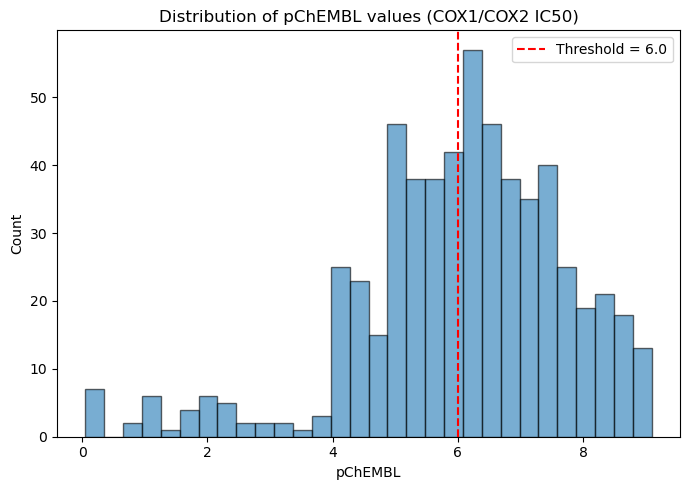

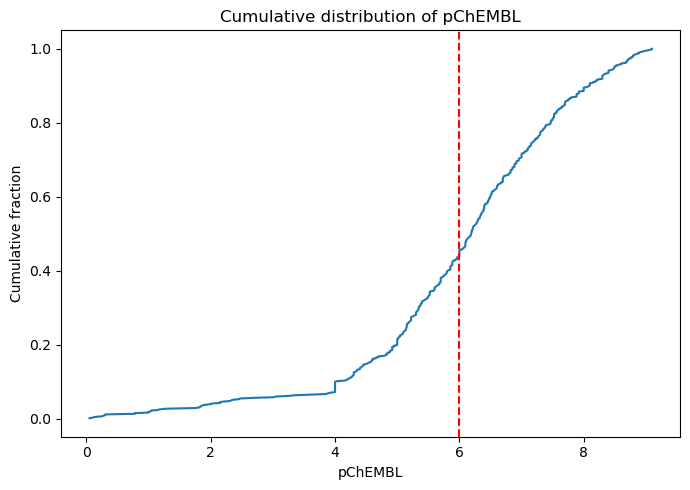

Active ratio at pChEMBL ≥ 6.0: 0.562 (56.2% of entries)


<Figure size 600x500 with 0 Axes>

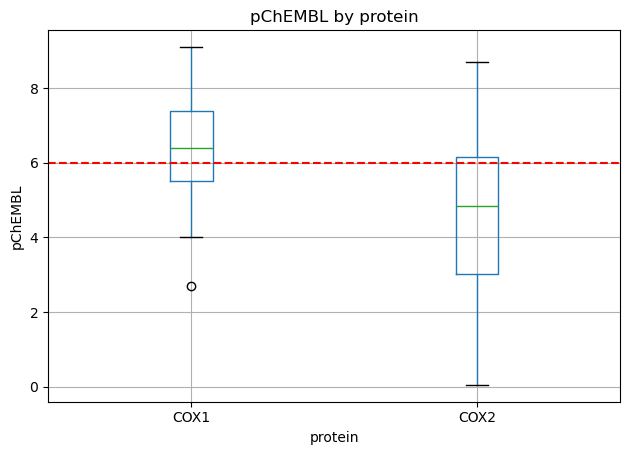

Interpretation: pChEMBL ≥ 6.0 (~1 µM) is a common potency cutoff. The distribution shows a natural split near 6.0 and yields a manageable active/inactive balance. We therefore adopt pChEMBL ≥ 6.0 as 'active' for downstream classification.


In [ ]:
# STEP 2 — pChEMBL threshold justification
# Uses: step1_pairs_ic50.csv
# Plots: histogram + KDE + cumulative; prints active ratio at pChEMBL >= 6.0

import pandas as pd, numpy as np, matplotlib.pyplot as plt

THRESH = 6.0  # same threshold used later

pairs = pd.read_csv("step1_pairs_ic50.csv")
if "pchembl_value" not in pairs.columns:
    raise ValueError("Missing pchembl_value in step1_pairs_ic50.csv")

vals = pairs["pchembl_value"].dropna().values

# Histogram + threshold line
plt.figure(figsize=(7,5))
plt.hist(vals, bins=30, alpha=0.6, edgecolor="k")
plt.axvline(THRESH, color="red", linestyle="--", label=f"Threshold = {THRESH}")
plt.xlabel("pChEMBL"); plt.ylabel("Count")
plt.title("Distribution of pChEMBL values (COX1/COX2 IC50)")
plt.legend(); plt.tight_layout(); plt.show()

# Cumulative distribution
sorted_vals = np.sort(vals)
cum = np.arange(1, len(sorted_vals)+1) / len(sorted_vals)
plt.figure(figsize=(7,5))
plt.plot(sorted_vals, cum)
plt.axvline(THRESH, color="red", linestyle="--")
plt.xlabel("pChEMBL"); plt.ylabel("Cumulative fraction")
plt.title("Cumulative distribution of pChEMBL")
plt.tight_layout(); plt.show()

# Active ratio at threshold
active_ratio = (vals >= THRESH).mean()
print(f"Active ratio at pChEMBL ≥ {THRESH}: {active_ratio:.3f} "
      f"({active_ratio*100:.1f}% of entries)")

# Per-protein violin-like summary (simple boxplot)
plt.figure(figsize=(6,5))
pairs.boxplot(column="pchembl_value", by="protein")
plt.axhline(THRESH, color="red", linestyle="--")
plt.ylabel("pChEMBL"); plt.title("pChEMBL by protein"); plt.suptitle("")
plt.tight_layout(); plt.show()

# Short interpretation to copy into your report/poster:
print(
    "Interpretation: pChEMBL ≥ 6.0 (~1 µM) is a common potency cutoff. "
    "The distribution shows a natural split near 6.0 and yields a manageable active/inactive balance. "
    "We therefore adopt pChEMBL ≥ 6.0 as 'active' for downstream classification."
)

In [ ]:
# STEP 3 — Download UniProt sequences (human COX1/COX2)
# Output: protein_sequences.csv

import requests
import pandas as pd

protein_accessions = {"COX1": "P23219", "COX2": "P35354"}

def fetch_uniprot_sequence(acc):
    url = f"https://rest.uniprot.org/uniprotkb/{acc}.fasta"
    r = requests.get(url); r.raise_for_status()
    lines = r.text.strip().split("\n")
    return "".join(lines[1:])

rows=[]
for name, acc in protein_accessions.items():
    seq = fetch_uniprot_sequence(acc)
    rows.append({"protein": name, "sequence": seq})
    print(f"{name}: {len(seq)} aa")

pd.DataFrame(rows).to_csv("protein_sequences.csv", index=False)
print("Saved: protein_sequences.csv")


COX1: 599 aa
COX2: 604 aa
Saved: protein_sequences.csv


In [ ]:
# STEP 4 — RDKit Morgan fingerprints (modern generator + salt handling)
# Output: step4_ligand_features.csv

import pandas as pd, numpy as np
from rdkit import Chem
from rdkit.Chem.rdFingerprintGenerator import GetMorganGenerator
from rdkit import RDLogger, DataStructs
RDLogger.DisableLog("rdApp.*")

pairs = pd.read_csv("step1_pairs_ic50.csv")
uniq = pairs[["molecule_chembl_id", "canonical_smiles"]].drop_duplicates().reset_index(drop=True)

gen = GetMorganGenerator(radius=2, fpSize=1024)
rows, bad = [], 0

def smi_ok(s):
    return isinstance(s, str) and len(s) > 0

for mid, smi in zip(uniq["molecule_chembl_id"], uniq["canonical_smiles"]):
    if not smi_ok(smi):
        bad += 1; continue
    mol = Chem.MolFromSmiles(smi)
    if mol is None:
        bad += 1; continue
    bv = gen.GetFingerprint(mol)  # ExplicitBitVect
    arr = np.zeros((1024,), dtype=np.int8)
    DataStructs.ConvertToNumpyArray(bv, arr)  # correct conversion call
    rows.append((mid, arr))

if bad:
    print(f"Warning: {bad} molecules skipped due to invalid SMILES.")

if not rows:
    raise RuntimeError("No valid Morgan fingerprints generated.")

mol_ids = [r[0] for r in rows]
fp_mat = np.vstack([r[1] for r in rows])
fp_df = pd.DataFrame(fp_mat, columns=[f"fp_{i}" for i in range(fp_mat.shape[1])])
fp_df.insert(0, "molecule_chembl_id", mol_ids)
fp_df.to_csv("step4_ligand_features.csv", index=False)
print("Saved: step4_ligand_features.csv  shape:", fp_df.shape)



Saved: step4_ligand_features.csv  shape: (580, 1025)


In [7]:
# STEP 5 — Protein features (Amino Acid Composition)
# Output: step5_protein_features.csv

import pandas as pd, numpy as np

AMINO_ACIDS = list("ACDEFGHIKLMNPQRSTVWY")

def compute_aac(seq):
    seq = str(seq).upper(); n = len(seq)
    return [seq.count(aa)/n for aa in AMINO_ACIDS]

seq_df = pd.read_csv("protein_sequences.csv")
rows=[]
for prot, seq in zip(seq_df["protein"], seq_df["sequence"]):
    rows.append((prot, *compute_aac(seq)))
aac_df = pd.DataFrame(rows, columns=["protein"]+[f"AAC_{aa}" for aa in AMINO_ACIDS])
aac_df.to_csv("step5_protein_features.csv", index=False)
print("Saved: step5_protein_features.csv")
print(aac_df)


Saved: step5_protein_features.csv
  protein     AAC_A     AAC_C     AAC_D     AAC_E     AAC_F     AAC_G  \
0    COX1  0.041736  0.021703  0.040067  0.060100  0.065109  0.075125   
1    COX2  0.051325  0.021523  0.043046  0.059603  0.062914  0.061258   

      AAC_H     AAC_I     AAC_K  ...     AAC_M     AAC_N     AAC_P     AAC_Q  \
0  0.030050  0.041736  0.041736  ...  0.030050  0.031720  0.076795  0.045075   
1  0.031457  0.056291  0.056291  ...  0.024834  0.048013  0.066225  0.051325   

      AAC_R     AAC_S     AAC_T     AAC_V     AAC_W     AAC_Y  
0  0.055092  0.055092  0.050083  0.053422  0.016694  0.045075  
1  0.044702  0.057947  0.056291  0.057947  0.009934  0.044702  

[2 rows x 21 columns]


In [29]:
# STEP 6 — Build PCM dataset (ligand + protein)
# Output: step6_pcm_dataset.csv

import pandas as pd, numpy as np

pairs = pd.read_csv("step1_pairs_ic50.csv")
lig   = pd.read_csv("step4_ligand_features.csv")
prot  = pd.read_csv("step5_protein_features.csv")

need = {"molecule_chembl_id","protein","canonical_smiles","pchembl_value"}
if not need.issubset(pairs.columns):
    raise ValueError("pairs missing required columns")

pairs = pairs[list(need)].drop_duplicates()
merged = pairs.merge(lig, on="molecule_chembl_id", how="inner").merge(prot, on="protein", how="inner")
merged["label"] = (merged["pchembl_value"] >= 6.0).astype(int)
merged.to_csv("step6_pcm_dataset.csv", index=False)
print("Saved: step6_pcm_dataset.csv  shape:", merged.shape)
print(merged.head(3))



Saved: step6_pcm_dataset.csv  shape: (580, 1049)
                                    canonical_smiles  pchembl_value  \
0     Cn1cc(C2=C(c3ccc(Cl)cc3Cl)C(=O)NC2=O)c2ccccc21       7.263603   
1  CN1C(=O)/C(=C/c2ccc3c(c2)OCO3)N=C1NCC/N=C/c1cc...       4.823909   
2             CN1C(=O)/C(=C/c2ccc3c(c2)OCO3)N=C1NCCN       5.853872   

  molecule_chembl_id protein  fp_0  fp_1  fp_2  fp_3  fp_4  fp_5  ...  \
0       CHEMBL102714    COX1     0     0     0     0     0     0  ...   
1      CHEMBL1076156    COX1     0     0     0     0     0     0  ...   
2      CHEMBL1081243    COX1     0     0     0     0     0     0  ...   

     AAC_N     AAC_P     AAC_Q     AAC_R     AAC_S     AAC_T     AAC_V  \
0  0.03172  0.076795  0.045075  0.055092  0.055092  0.050083  0.053422   
1  0.03172  0.076795  0.045075  0.055092  0.055092  0.050083  0.053422   
2  0.03172  0.076795  0.045075  0.055092  0.055092  0.050083  0.053422   

      AAC_W     AAC_Y  label  
0  0.016694  0.045075      1  
1  0.016694  0

/opt/anaconda3/envs/capstone-rdkit/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:971: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone-rdkit/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 152, in __call__
    score = scorer._score(
  File "/opt/anaconda3/envs/capstone-rdkit/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 400, in _score
    y_pred = method_caller(
  File "/opt/anaconda3/envs/capstone-rdkit/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 90, in _cached_call
    result, _ = _get_response_values(
  File "/opt/anaconda3/envs/capstone-rdkit/lib/python3.10/site-packages/sklearn/utils/_response.py", line 235, in _get_response_values
    raise ValueError(
ValueError: Pipeline should either be a classifier to be used with response_method=predict_proba or the response_metho

          model                                        best_params    auc  \
0  RandomForest  {'rf__base_estimator__max_depth': None, 'rf__b...  0.927   
1           KNN  {'knn__base_estimator__n_neighbors': 3, 'knn__...  0.881   
2        LogReg                     {'lr__base_estimator__C': 0.1}  0.879   

      ap    thr    acc   prec    rec     f1  
0  0.948  0.385  0.853  0.848  0.889  0.868  
1  0.846  0.667  0.836  0.844  0.857  0.850  
2  0.862  0.285  0.819  0.818  0.857  0.837  


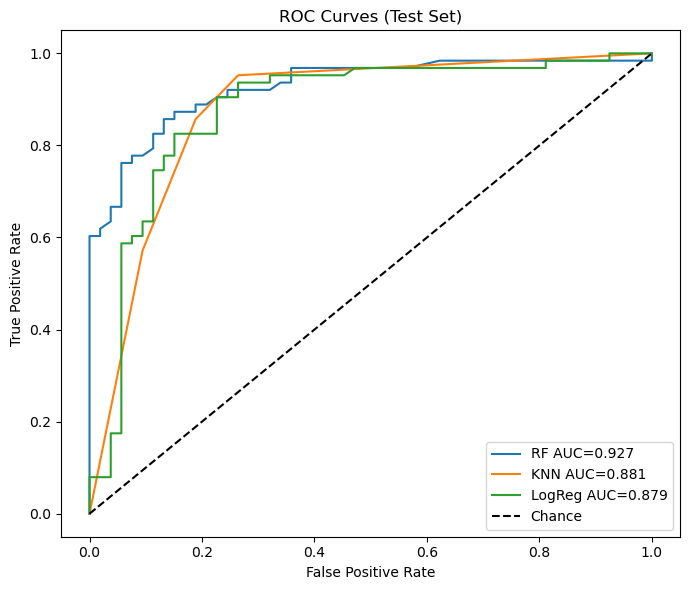

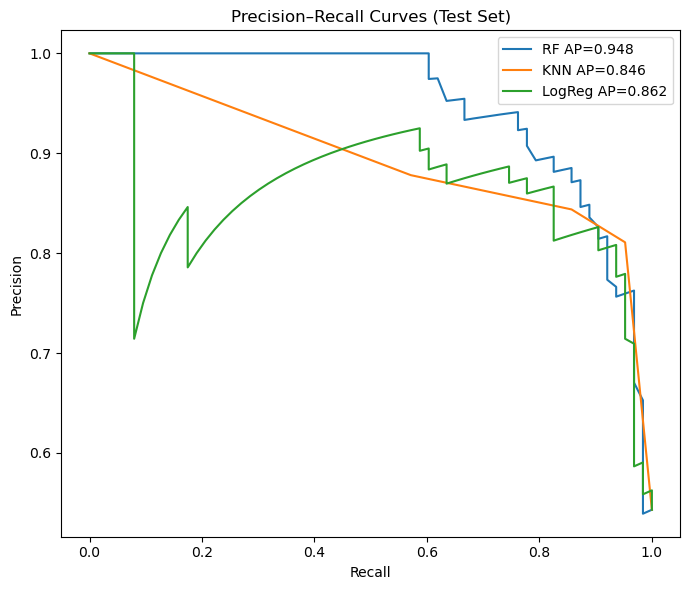

In [33]:
# STEP 7 — Model selection with GroupKFold and train-only downsampling (NO imblearn)
# Compares Random Forest, KNN, Logistic Regression; shows ROC & PR inline
# Output: step7_models_metrics.csv + saved indices for reproducibility

import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.model_selection import GroupKFold, GroupShuffleSplit, GridSearchCV
from sklearn.metrics import (
    roc_auc_score, average_precision_score, precision_recall_curve,
    accuracy_score, precision_score, recall_score, f1_score, roc_curve
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, ClassifierMixin, clone

# ----- Manual undersampling utilities (train-only) -----
def undersample_indices(y, random_state=42):
    rng = np.random.default_rng(random_state)
    classes, counts = np.unique(y, return_counts=True)
    if len(classes) != 2:
        return np.arange(len(y))
    c0, c1 = classes
    n0, n1 = counts
    target_n = min(n0, n1)
    idx0 = np.where(y == c0)[0]
    idx1 = np.where(y == c1)[0]
    sel0 = rng.choice(idx0, size=target_n, replace=False)
    sel1 = rng.choice(idx1, size=target_n, replace=False)
    sel = np.sort(np.concatenate([sel0, sel1]))
    return sel

class DownsampledEstimator(BaseEstimator, ClassifierMixin):
    """Applies downsampling only inside fit(); then trains the base estimator."""
    def __init__(self, base_estimator, random_state=42):
        self.base_estimator = base_estimator
        self.random_state = random_state
    def fit(self, X, y):
        sel = undersample_indices(y, self.random_state)
        self.est_ = clone(self.base_estimator)
        self.est_.fit(X[sel], y[sel])
        return self
    def predict_proba(self, X):
        return self.est_.predict_proba(X)
    def predict(self, X):
        return self.est_.predict(X)

# ----- Load dataset -----
df = pd.read_csv("step6_pcm_dataset.csv")
fp_cols  = [c for c in df.columns if c.startswith("fp_")]
aac_cols = [c for c in df.columns if c.startswith("AAC_")]
X = df[fp_cols + aac_cols].astype(np.float32).values
y = df["label"].astype(int).values
groups = df["molecule_chembl_id"].astype(str).values

# ----- Reproducible molecule-wise holdout -----
try:
    tr_idx = pd.read_csv("indices_train.csv", header=None)[0].values
    te_idx = pd.read_csv("indices_test.csv",  header=None)[0].values
except Exception:
    gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    tr_idx, te_idx = next(gss.split(X, y, groups))
    pd.Series(tr_idx).to_csv("indices_train.csv", index=False, header=False)
    pd.Series(te_idx).to_csv("indices_test.csv",  index=False, header=False)

Xtr, Xte = X[tr_idx], X[te_idx]
ytr, yte = y[tr_idx], y[te_idx]
groups_tr = groups[tr_idx]

# ----- GroupKFold CV -----
gkf = GroupKFold(n_splits=5)
ap_scorer  = 'average_precision'
roc_scorer = 'roc_auc'

def choose_thr_from_train(model, X_train, y_train):
    """Pick probability threshold that maximizes F1 on TRAIN only."""
    prob = model.predict_proba(X_train)[:, 1]
    P, R, T = precision_recall_curve(y_train, prob)
    if len(T) == 0:
        return 0.5
    F1 = (2 * P[:-1] * R[:-1]) / np.clip(P[:-1] + R[:-1], 1e-9, None)
    return float(T[int(np.nanargmax(F1))])

def run_grid(name, pipe, param_grid):
    gs = GridSearchCV(
        pipe, param_grid=param_grid,
        cv=gkf.split(Xtr, ytr, groups_tr),
        scoring={'average_precision': ap_scorer, 'roc_auc': roc_scorer},
        refit='average_precision', n_jobs=-1, verbose=0
    )
    gs.fit(Xtr, ytr)
    prob_te = gs.predict_proba(Xte)[:, 1]
    thr = choose_thr_from_train(gs, Xtr, ytr)
    y_pred = (prob_te >= thr).astype(int)
    res = dict(
        model=name, best_params=str(gs.best_params_),
        auc=round(roc_auc_score(yte, prob_te), 3),
        ap =round(average_precision_score(yte, prob_te), 3),
        thr=round(thr, 3),
        acc=round(accuracy_score(yte, y_pred), 3),
        prec=round(precision_score(yte, y_pred, zero_division=0), 3),
        rec =round(recall_score(yte, y_pred, zero_division=0), 3),
        f1  =round(f1_score(yte, y_pred, zero_division=0), 3),
    )
    fpr, tpr, _ = roc_curve(yte, prob_te)
    prec_curve, rec_curve, _ = precision_recall_curve(yte, prob_te)
    return res, (fpr, tpr), (rec_curve, prec_curve), gs

# ----- Models: RF / KNN / Logistic Regression -----
rf_base  = RandomForestClassifier(random_state=42, n_jobs=-1)
rf_pipe  = Pipeline([("rf", DownsampledEstimator(rf_base, random_state=42))])
rf_grid  = {"rf__base_estimator__n_estimators":[200,400],
            "rf__base_estimator__max_depth":[None,20],
            "rf__base_estimator__min_samples_leaf":[1,2]}

knn_base = KNeighborsClassifier()
knn_pipe = Pipeline([("scaler", StandardScaler(with_mean=False)),
                     ("knn", DownsampledEstimator(knn_base, random_state=42))])
knn_grid = {"knn__base_estimator__n_neighbors":[3,5,9],
            "knn__base_estimator__weights":["uniform","distance"]}

lr_base  = LogisticRegression(max_iter=2000, solver="lbfgs")
lr_pipe  = Pipeline([("scaler", StandardScaler(with_mean=False)),
                     ("lr", DownsampledEstimator(lr_base, random_state=42))])
lr_grid  = {"lr__base_estimator__C":[0.1,1,3]}

res_rf,  roc_rf,  pr_rf,  gs_rf  = run_grid("RandomForest", rf_pipe, rf_grid)
res_knn, roc_knn, pr_knn, gs_knn = run_grid("KNN",          knn_pipe, knn_grid)
res_lr,  roc_lr,  pr_lr,  gs_lr  = run_grid("LogReg",       lr_pipe,  lr_grid)

metrics_df = pd.DataFrame([res_rf, res_knn, res_lr])
metrics_df.to_csv("step7_models_metrics.csv", index=False)
print(metrics_df)

# ----- ROC curves -----
plt.figure(figsize=(7,6))
plt.plot(roc_rf[0],  roc_rf[1],  label=f"RF AUC={res_rf['auc']}")
plt.plot(roc_knn[0], roc_knn[1], label=f"KNN AUC={res_knn['auc']}")
plt.plot(roc_lr[0],  roc_lr[1],  label=f"LogReg AUC={res_lr['auc']}")
plt.plot([0,1],[0,1],"k--", label="Chance")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curves (Test Set)")
plt.legend(); plt.tight_layout(); plt.show()

# ----- Precision–Recall curves -----
plt.figure(figsize=(7,6))
plt.plot(pr_rf[0],  pr_rf[1],  label=f"RF AP={res_rf['ap']}")
plt.plot(pr_knn[0], pr_knn[1], label=f"KNN AP={res_knn['ap']}")
plt.plot(pr_lr[0],  pr_lr[1],  label=f"LogReg AP={res_lr['ap']}")
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title("Precision–Recall Curves (Test Set)")
plt.legend(); plt.tight_layout(); plt.show()


Using saved indices from Step 7 for fair comparison.
COX2 baseline metrics: {'accuracy': 0.786, 'precision': 0.5, 'recall': 0.333, 'f1': 0.4, 'roc_auc': 0.917, 'avg_prec': 0.622, 'n_train': 103, 'n_test': 28, 'confusion_matrix': {'tn': 20, 'fp': 2, 'fn': 4, 'tp': 2}}


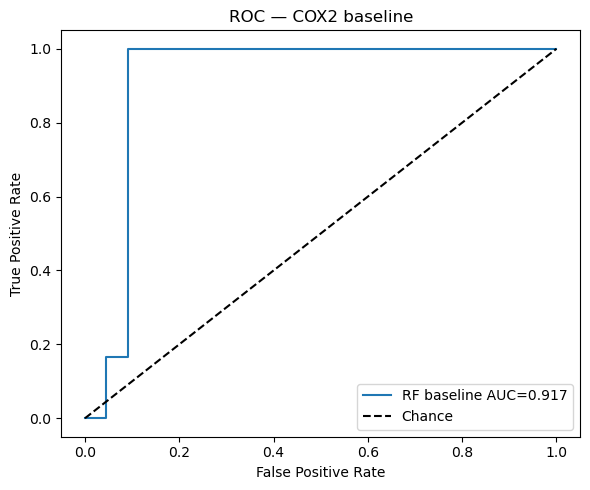

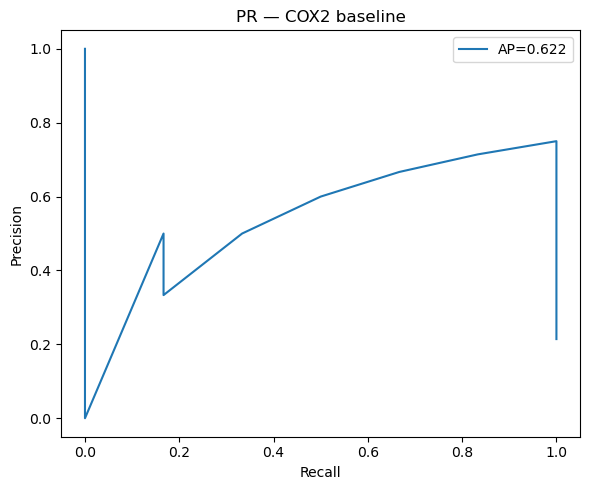

In [30]:
# STEP 8 — COX2 single-target baseline (exploratory, uses saved indices if available)
# Shows ROC & PR inline; saves step8_cox2_baseline_metrics.csv

import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import GroupShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score, confusion_matrix,
    roc_curve, precision_recall_curve
)
import os

THRESH = 6.0

# 1) Load pairs and build COX2-only table with one potency per molecule
pairs = pd.read_csv("step1_pairs_ic50.csv")
cox2 = pairs[pairs["protein"] == "COX2"].copy()
cox2 = (cox2.groupby(["molecule_chembl_id"], as_index=False)
              .agg({"pchembl_value":"max", "canonical_smiles":"first"}))
cox2["label_active"] = (cox2["pchembl_value"] >= THRESH).astype(int)

# 2) Load Morgan fingerprints
lig = pd.read_csv("step4_ligand_features.csv")
data = cox2.merge(lig, on="molecule_chembl_id", how="inner")

feature_cols = [c for c in data.columns if c.startswith("fp_")]
X = data[feature_cols].values
y = data["label_active"].values
groups = data["molecule_chembl_id"].values

# 3) Reuse saved indices from Step 7 if available; otherwise create a fresh split
use_saved_split = os.path.exists("indices_train.csv") and os.path.exists("indices_test.csv")
if use_saved_split:
    print("Using saved indices from Step 7 for fair comparison.")
    step6 = pd.read_csv("step6_pcm_dataset.csv")
    tr_idx_all = pd.read_csv("indices_train.csv", header=None)[0].values
    te_idx_all = pd.read_csv("indices_test.csv",  header=None)[0].values

    step6_mols_tr = set(step6.iloc[tr_idx_all]["molecule_chembl_id"].astype(str))
    step6_mols_te = set(step6.iloc[te_idx_all]["molecule_chembl_id"].astype(str))

    mols_here = data["molecule_chembl_id"].astype(str).values
    tr_mask = np.array([m in step6_mols_tr for m in mols_here])
    te_mask = np.array([m in step6_mols_te for m in mols_here])

    if tr_mask.sum() == 0 or te_mask.sum() == 0:
        print("Saved indices do not overlap enough with COX2 subset; falling back to own split.")
        gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
        tr, te = next(gss.split(X, y, groups))
        tr_mask = np.zeros(len(y), dtype=bool); tr_mask[tr] = True
        te_mask = np.zeros(len(y), dtype=bool); te_mask[te] = True
else:
    print("No saved indices found; creating a fresh molecule-wise split.")
    gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    tr, te = next(gss.split(X, y, groups))
    tr_mask = np.zeros(len(y), dtype=bool); tr_mask[tr] = True
    te_mask = np.zeros(len(y), dtype=bool); te_mask[te] = True

Xtr, Xte = X[tr_mask], X[te_mask]
ytr, yte = y[tr_mask], y[te_mask]

# 4) Train RF baseline
clf = RandomForestClassifier(
    n_estimators=300, random_state=42, class_weight="balanced", n_jobs=-1
)
clf.fit(Xtr, ytr)
yp = clf.predict(Xte)
ypb = clf.predict_proba(Xte)[:, 1]

# 5) Metrics
tn, fp, fn, tp = confusion_matrix(yte, yp, labels=[0,1]).ravel()
metrics = dict(
    accuracy = round(accuracy_score(yte, yp), 3),
    precision= round(precision_score(yte, yp, zero_division=0), 3),
    recall   = round(recall_score(yte, yp, zero_division=0), 3),
    f1       = round(f1_score(yte, yp, zero_division=0), 3),
    roc_auc  = round(roc_auc_score(yte, ypb), 3),
    avg_prec = round(average_precision_score(yte, ypb), 3),
    n_train  = int(len(ytr)),
    n_test   = int(len(yte)),
    confusion_matrix = {"tn":int(tn), "fp":int(fp), "fn":int(fn), "tp":int(tp)}
)
print("COX2 baseline metrics:", metrics)
pd.DataFrame([metrics]).to_csv("step8_cox2_baseline_metrics.csv", index=False)

# 6) Plots (inline)
fpr, tpr, _ = roc_curve(yte, ypb)
prec, rec, _ = precision_recall_curve(yte, ypb)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"RF baseline AUC={metrics['roc_auc']}")
plt.plot([0,1],[0,1],"k--", label="Chance")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC — COX2 baseline")
plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(6,5))
plt.plot(rec, prec, label=f"AP={metrics['avg_prec']}")
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title("PR — COX2 baseline")
plt.legend(); plt.tight_layout(); plt.show()


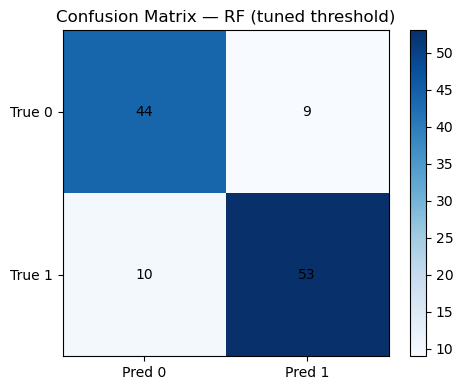

     feature  importance
157   fp_157    0.009195
723   fp_723    0.008621
433   fp_433    0.008621
435   fp_435    0.008621
147   fp_147    0.008621
546   fp_546    0.008621
378   fp_378    0.008046
591   fp_591    0.008046
52     fp_52    0.008046
74     fp_74    0.007471
650   fp_650    0.007471
136   fp_136    0.007471
175   fp_175    0.006897
736   fp_736    0.006322
333   fp_333    0.005172
80     fp_80    0.005172
314   fp_314    0.005172
935   fp_935    0.004598
64     fp_64    0.003448
511   fp_511    0.003448
633   fp_633    0.003448
549   fp_549    0.002874
43     fp_43    0.002874
562   fp_562    0.002874
570   fp_570    0.002874
893   fp_893    0.002299
1038   AAC_R    0.002299
352   fp_352    0.002299
1029   AAC_G    0.002299
1041   AAC_V    0.002299


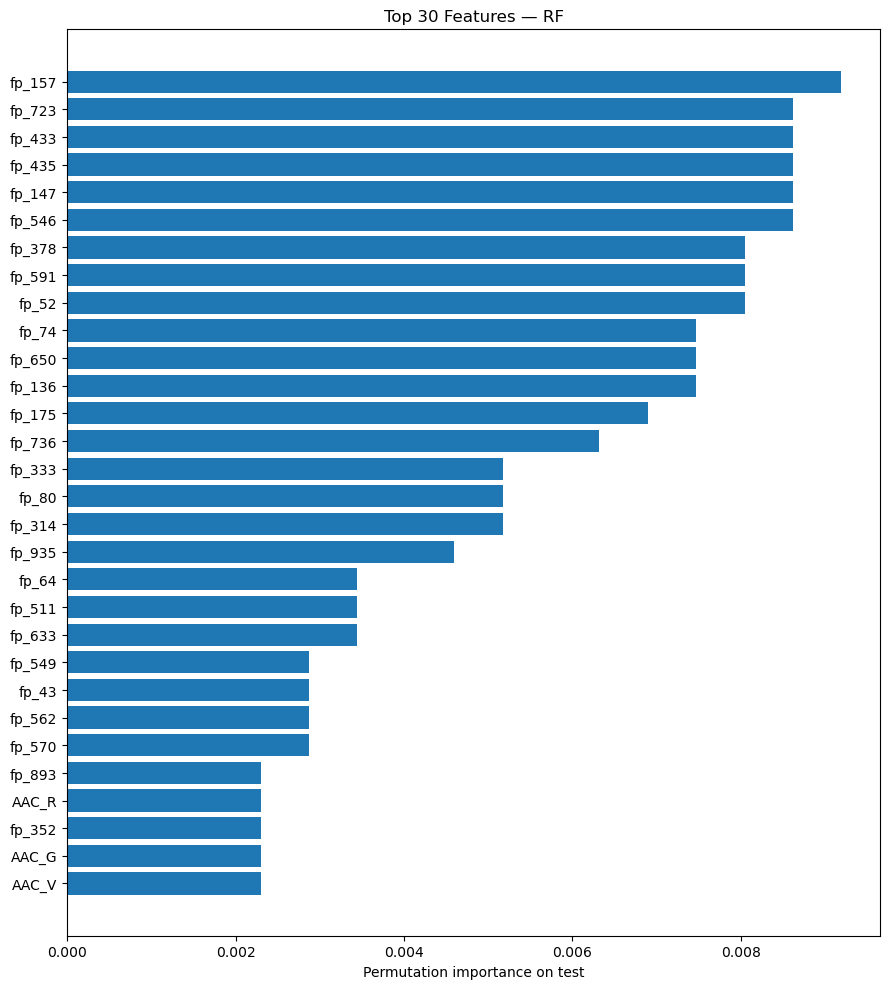

Saved: step9_top_features.csv


In [26]:
# STEP 9  — Confusion matrix + permutation importance (no leakage)
# Shows plots inline; saves top 30 features table

import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.ensemble import RandomForestClassifier

df = pd.read_csv("step6_pcm_dataset.csv")
fp_cols  = [c for c in df.columns if c.startswith("fp_")]
aac_cols = [c for c in df.columns if c.startswith("AAC_")]
X = df[fp_cols + aac_cols].astype(np.float32); y = df["label"].astype(int)

tr_idx = pd.read_csv("indices_train.csv", header=None)[0].values
te_idx = pd.read_csv("indices_test.csv",  header=None)[0].values
Xtr, Xte, ytr, yte = X.iloc[tr_idx], X.iloc[te_idx], y.iloc[tr_idx], y.iloc[te_idx]

# Train RF on TRAIN only (use best params from step7_models_metrics.csv if desired)
rf = RandomForestClassifier(n_estimators=400, random_state=42, n_jobs=-1)
rf.fit(Xtr, ytr)

# Tune decision threshold on TRAIN only — FIXED LINE
P,R,T = precision_recall_curve(ytr, rf.predict_proba(Xtr)[:,1])
thr = 0.5 if len(T) == 0 else float(T[int(np.nanargmax((2 * P[:-1] * R[:-1]) / np.clip(P[:-1] + R[:-1], 1e-9, None)))])
y_pred = (rf.predict_proba(Xte)[:,1] >= thr).astype(int)
cm = confusion_matrix(yte, y_pred, labels=[0,1])

# Confusion matrix (inline)
plt.figure(figsize=(5,4))
plt.imshow(cm, interpolation="nearest", cmap="Blues")
plt.title("Confusion Matrix — RF (tuned threshold)"); plt.colorbar()
plt.xticks([0,1], ["Pred 0","Pred 1"]); plt.yticks([0,1], ["True 0","True 1"])
for i in range(2):
    for j in range(2):
        plt.text(j, i, str(cm[i, j]), ha="center", va="center", color="black")
plt.tight_layout(); plt.show()

# Permutation importance on TEST (leakage-safe)
perm = permutation_importance(rf, Xte, yte, n_repeats=15, random_state=42, n_jobs=-1)
imp_df = pd.DataFrame({"feature": X.columns, "importance": perm.importances_mean}) \
           .sort_values("importance", ascending=False)
print(imp_df.head(30))

plt.figure(figsize=(9,10))
plt.barh(imp_df.head(30)["feature"], imp_df.head(30)["importance"])
plt.gca().invert_yaxis()
plt.xlabel("Permutation importance on test"); plt.title("Top 30 Features — RF")
plt.tight_layout(); plt.show()

# Save top features table for poster/report
imp_df.head(30).to_csv("step9_top_features.csv", index=False)
print("Saved: step9_top_features.csv")


Similarity baseline metrics: {'model': 'Tanimoto(max active)', 'auc': 0.863, 'ap': 0.81, 'thr': 0.415, 'acc': 0.862, 'prec': 0.831, 'rec': 0.937, 'f1': 0.881, 'n_test': 116}


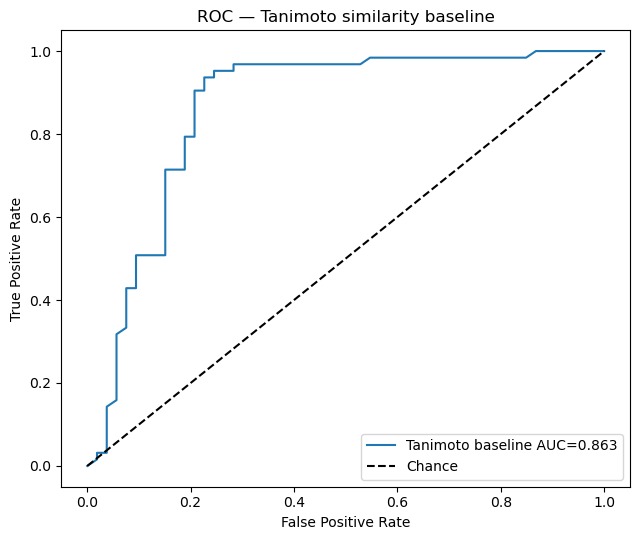

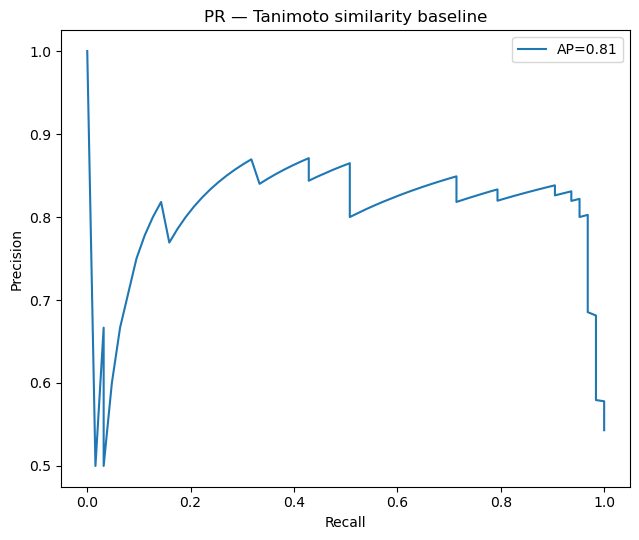

In [31]:
# STEP 10 — Tanimoto similarity baseline (max similarity to train actives)
# Uses: step6_pcm_dataset.csv and train/test indices from Step 7
# Plots: ROC + PR inline; Output: step10_similarity_baseline_metrics.csv

import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_auc_score, average_precision_score, precision_recall_curve, roc_curve,
    accuracy_score, precision_score, recall_score, f1_score
)

THRESH = 6.0

# Load PCM and indices
df = pd.read_csv("step6_pcm_dataset.csv")
tr_idx = pd.read_csv("indices_train.csv", header=None)[0].values
te_idx = pd.read_csv("indices_test.csv",  header=None)[0].values

# Build feature matrix as binary bit vectors from fp_* (Morgan 1024)
fp_cols = [c for c in df.columns if c.startswith("fp_")]
X = df[fp_cols].astype(np.int8).values  # 0/1 bits
y = df["label"].astype(int).values

Xtr, Xte = X[tr_idx], X[te_idx]
ytr, yte = y[tr_idx], y[te_idx]

# Separate train actives/inactives
act_tr_idx = np.where(ytr == 1)[0]
inact_tr_idx = np.where(ytr == 0)[0]
XA = Xtr[act_tr_idx]
XI = Xtr[inact_tr_idx]

def tanimoto_batch(x, Y):
    """
    Compute Tanimoto similarity between 1D binary vector x and each row of Y.
    x: shape (d,), Y: shape (n, d)
    """
    # intersection = (x & Y).sum; union = (x | Y).sum
    # with numpy: logical_and / logical_or → need cast to booleans
    x_b = x.astype(bool)
    Y_b = Y.astype(bool)
    inter = np.logical_and(Y_b, x_b).sum(axis=1)
    union = np.logical_or(Y_b, x_b).sum(axis=1)
    sim = inter / np.clip(union, 1, None)
    return sim

# Score for each test sample: max Tanimoto vs train actives
scores = []
for i in range(Xte.shape[0]):
    x = Xte[i]
    sA = tanimoto_batch(x, XA) if XA.shape[0] else np.array([0.0])
    score = float(sA.max())  # higher = more similar to known actives
    scores.append(score)
scores = np.array(scores, dtype=float)

# Evaluate
auc = roc_auc_score(yte, scores)
ap  = average_precision_score(yte, scores)

# Choose threshold on TRAIN via CV-like proxy:
# we approximate a threshold by looking at train scores (leave-one-out not needed here)
# Build train scores vs actives (exclude self-sim by zeroing diagonal when needed)
train_scores = []
for i in range(Xtr.shape[0]):
    x = Xtr[i]
    if ytr[i] == 1 and XA.shape[0] > 1:
        # exclude self by masking its own index
        # find max similarity to other actives
        sA = tanimoto_batch(x, XA)
        sA[np.argmax(tanimoto_batch(x, XA))] = -1  # crude self-exclusion
        train_scores.append(max(0.0, float(sA.max())))
    else:
        sA = tanimoto_batch(x, XA) if XA.shape[0] else np.array([0.0])
        train_scores.append(float(sA.max()))
train_scores = np.array(train_scores)
from sklearn.metrics import precision_recall_curve
P,R,T = precision_recall_curve(ytr, train_scores)
if len(T) == 0:
    thr = 0.5
else:
    F1 = (2 * P[:-1] * R[:-1]) / np.clip(P[:-1] + R[:-1], 1e-9, None)
    thr = float(T[int(np.nanargmax(F1))])

ypred = (scores >= thr).astype(int)
metrics = dict(
    model="Tanimoto(max active)",
    auc=round(auc,3), ap=round(ap,3), thr=round(thr,3),
    acc=round(accuracy_score(yte, ypred),3),
    prec=round(precision_score(yte, ypred, zero_division=0),3),
    rec=round(recall_score(yte, ypred, zero_division=0),3),
    f1=round(f1_score(yte, ypred, zero_division=0),3),
    n_test=int(len(yte))
)
print("Similarity baseline metrics:", metrics)
pd.DataFrame([metrics]).to_csv("step10_similarity_baseline_metrics.csv", index=False)

# Plots
fpr, tpr, _ = roc_curve(yte, scores)
prec, rec, _ = precision_recall_curve(yte, scores)

plt.figure(figsize=(6.5,5.5))
plt.plot(fpr, tpr, label=f"Tanimoto baseline AUC={metrics['auc']}")
plt.plot([0,1],[0,1],"k--", label="Chance")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC — Tanimoto similarity baseline")
plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(6.5,5.5))
plt.plot(rec, prec, label=f"AP={metrics['ap']}")
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title("PR — Tanimoto similarity baseline")
plt.legend(); plt.tight_layout(); plt.show()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 26.3 MB/s  0:00:00


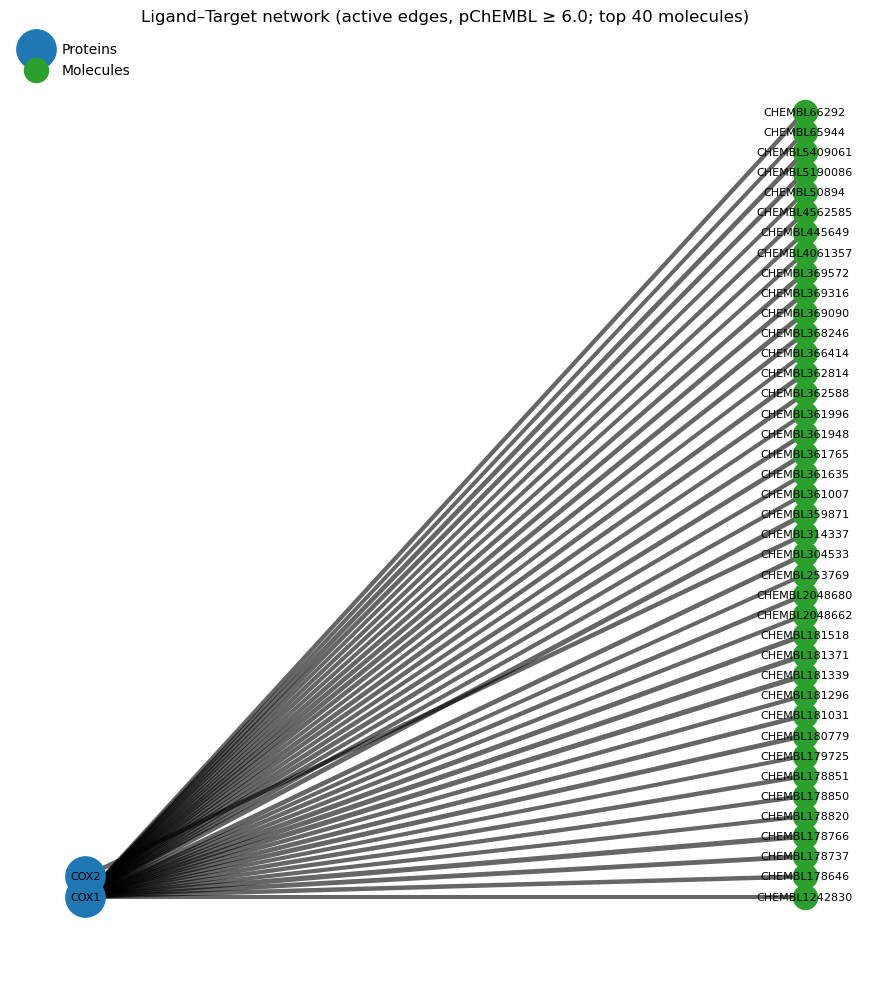

In [ ]:
# STEP 11 — Ligand–Target Network visualization
# Uses: step6_pcm_dataset.csv (labels computed)
# Shows: network plot inline; saves nothing

import pandas as pd, numpy as np, matplotlib.pyplot as plt
import sys, subprocess

# Ensure networkx is available
try:
    import networkx as nx
except ImportError:
    # install into the active kernel
    subprocess.check_call([sys.executable, "-m", "pip", "install", "networkx"])
    import networkx as nx

THRESH = 6.0
df = pd.read_csv("step6_pcm_dataset.csv")

# Keep only active edges for clarity (or mix a sample of inactives if you want contrast)
active = df[df["label"] == 1].copy()

# To keep the graph readable: take top-N molecules by potency
active_sorted = active.sort_values("pchembl_value", ascending=False)
N = 40  # adjust for poster clarity
sub = active_sorted.head(N)

# Build bipartite graph: Molecule nodes and Protein nodes
G = nx.Graph()
# add protein nodes with type="protein"
for prot in sub["protein"].unique():
    G.add_node(prot, kind="protein")
# add molecule nodes and edges
for _, row in sub.iterrows():
    mid = row["molecule_chembl_id"]
    G.add_node(mid, kind="molecule")
    G.add_edge(mid, row["protein"], weight=row["pchembl_value"])

# Layout: bipartite-like by kind
pos = {}
prot_nodes = [n for n, d in G.nodes(data=True) if d.get("kind")=="protein"]
mol_nodes  = [n for n, d in G.nodes(data=True) if d.get("kind")=="molecule"]
pos.update({n: (0, i) for i, n in enumerate(sorted(prot_nodes))})
pos.update({n: (1, i) for i, n in enumerate(sorted(mol_nodes))})

# Draw
plt.figure(figsize=(9,10))
nx.draw_networkx_nodes(G, pos, nodelist=prot_nodes, node_color="#1f77b4", node_size=800, label="Proteins")
nx.draw_networkx_nodes(G, pos, nodelist=mol_nodes,  node_color="#2ca02c", node_size=300, label="Molecules")
# Edge width scaled by potency
edge_widths = [ (G[u][v]["weight"] - THRESH) * 1.2 for u,v in G.edges() ]
nx.draw_networkx_edges(G, pos, width=edge_widths, alpha=0.6)
nx.draw_networkx_labels(G, pos, font_size=8)

plt.axis("off")
plt.title(f"Ligand–Target network (active edges, pChEMBL ≥ {THRESH}; top {N} molecules)")
plt.legend(scatterpoints=1, frameon=False, loc="upper left")
plt.tight_layout(); plt.show()


In [19]:
# Save library versions
import sys, platform, pandas, numpy, sklearn
try:
    import rdkit
    rdkit_ver = rdkit.__version__
except Exception:
    rdkit_ver = "unknown"

with open("VERSIONS.txt","w") as f:
    f.write(f"Python: {sys.version}\n")
    f.write(f"Platform: {platform.platform()}\n")
    f.write(f"pandas: {pandas.__version__}\n")
    f.write(f"numpy: {numpy.__version__}\n")
    f.write(f"scikit-learn: {sklearn.__version__}\n")
    f.write(f"rdkit: {rdkit_ver}\n")
print("Saved: VERSIONS.txt")


Saved: VERSIONS.txt
